# 10_K2_pseudobulk.ipynb

1. Produce a simple lattice graph structure derived spatially
1. For each possible pair of cells/spots --> sum their expression values
1. Run SIMBA on this merged cells.

Local communities in a homogenous region will look the same. Local communities at borders will look different. 

In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, plot_obs_spatial
import pandas as pd
import numpy as np
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"
from mpl_toolkits.axes_grid1 import make_axes_locatable
import anndata as ad


In [3]:
import os
import simba as si

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_simba_only/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [75]:
workdir = 'data/10'
si.settings.set_workdir(workdir)

Saving results in: data/10


In [76]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

# make plots prettier
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

In [79]:
adata_fn = "/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/data/human_DLPFC/151507.h5ad"
adata = sc.read_h5ad(adata_fn)

## Generate pairwise gene expression data

In [80]:
adata

AnnData object with n_obs × n_vars = 4221 × 15818
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [81]:
# ChatGPT
import numpy as np
from scipy.spatial import KDTree

def sum_adjacent_cells(expression_matrix, coordinates, distance_threshold=1.0):
    """
    Compute the sum of expression levels for all pairs of adjacent cells.

    Parameters:
        expression_matrix (ndarray): Shape (n, m), expression levels of m genes in n cells.
        coordinates (ndarray): Shape (n, 2), (x, y) spatial coordinates of n cells.
        distance_threshold (float): Maximum distance to consider cells as adjacent.

    Returns:
        list of tuples: [(index1, index2, summed_expression)], where summed_expression is shape (m,).
    """
    tree = KDTree(coordinates)
    pairs = tree.query_pairs(distance_threshold)  # Get indices of adjacent cells

    summed_expressions = [
        (i, j, expression_matrix[i] + expression_matrix[j])
        for i, j in pairs
    ]
    
    return summed_expressions

In [83]:
tree = KDTree(adata.obsm['spatial'])

In [84]:
spots = adata.obsm['spatial']

Already deduplicated

In [85]:
pairs = tree.query_pairs(250)  # by eye

In [86]:
len(pairs)

24581

In [88]:
pair_idx = np.array(list(pairs))
pair_idx

array([[ 682, 4118],
       [ 100,  730],
       [1826, 2291],
       ...,
       [ 129, 1310],
       [ 720, 3471],
       [1385, 3861]])

In [89]:
cell_1_bc = adata.obs_names[pair_idx[:, 0]].to_numpy()
cell_2_bc = adata.obs_names[pair_idx[:, 1]].to_numpy()

In [90]:
obs_df = pd.DataFrame(
    {
        'cell_1_barcode': cell_1_bc,
        'cell_2_barcode': cell_2_bc,
    }
)

Average of their locations

In [91]:
pair_spatial = (adata[cell_1_bc].obsm['spatial'] + adata[cell_2_bc].obsm['spatial']) / 2

In [92]:
cell_1_X = adata[cell_1_bc].X
cell_2_X = adata[cell_2_bc].X

In [100]:
k2_adata = ad.AnnData(
    X=cell_1_X + cell_2_X,
    obs=obs_df,
    var=adata.var.copy()
)
k2_adata.obsm['spatial'] = pair_spatial

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_simba_only/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [101]:
k2_adata

AnnData object with n_obs × n_vars = 24581 × 15818
    obs: 'cell_1_barcode', 'cell_2_barcode'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

# SIMBA

In [102]:
si.pp.cal_qc_rna(k2_adata)

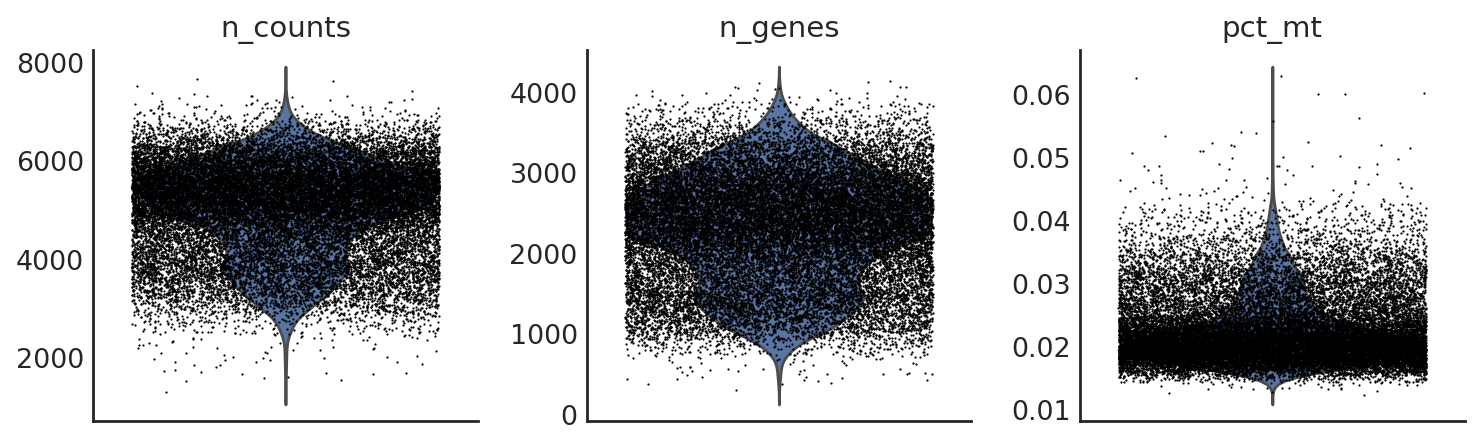

In [103]:
si.pl.violin(k2_adata,list_obs=['n_counts','n_genes','pct_mt'])

In [104]:
si.pp.normalize(k2_adata,method='lib_size')
si.pp.log_transform(k2_adata)

2000 variable genes are selected.


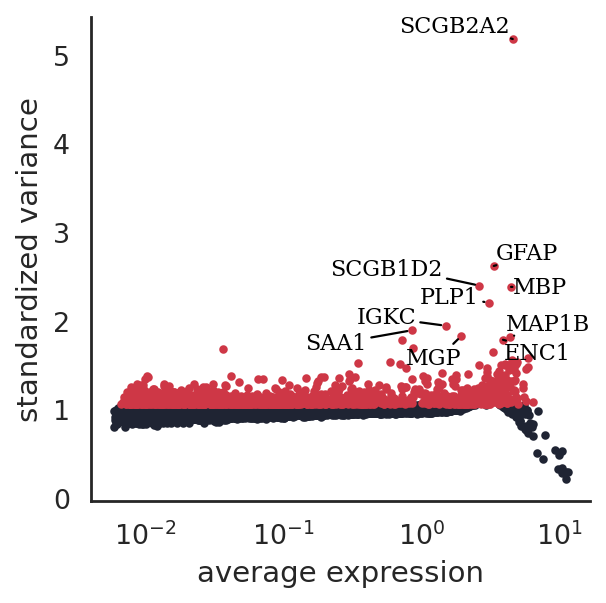

In [105]:
si.pp.select_variable_genes(k2_adata, n_top_genes=2000)
si.pl.variable_genes(k2_adata,show_texts=True)

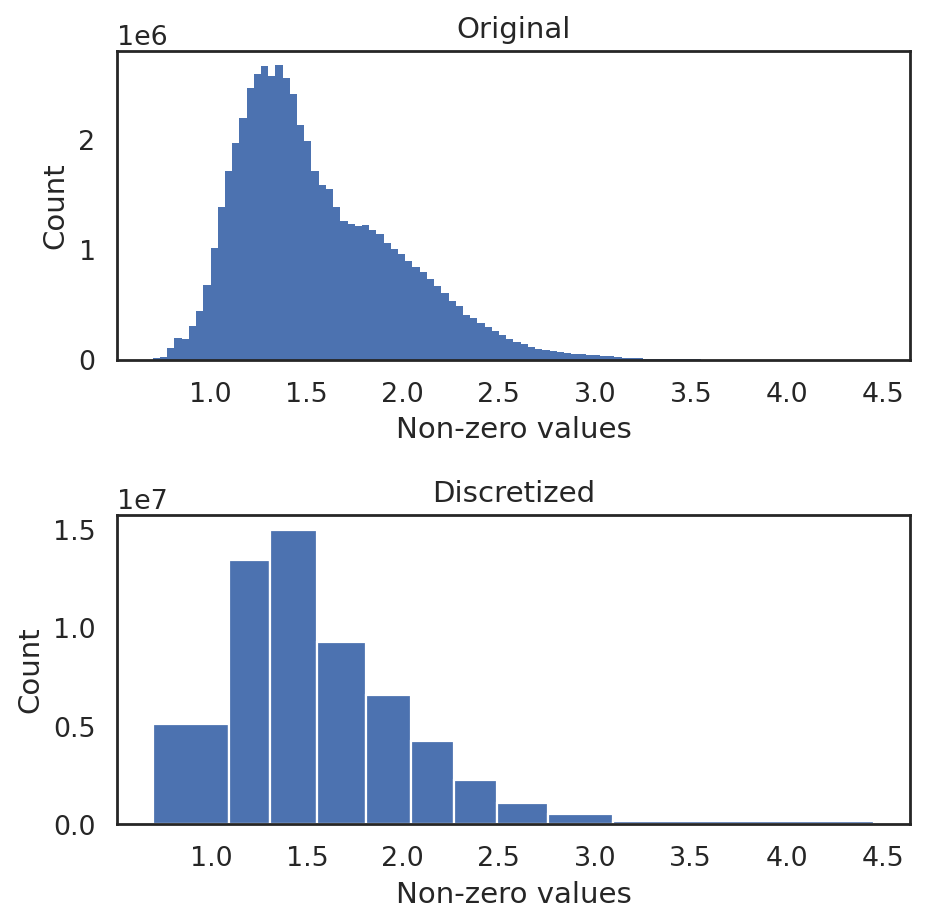

In [107]:
si.tl.discretize(k2_adata,n_bins=10)
si.pl.discretize(k2_adata,kde=False)

In [108]:
si.tl.gen_graph(list_CG=[k2_adata],
                layer='simba',
                use_highly_variable=False,
                dirname='graph0')

Processing CG: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


relation0: source: C, destination: G
#edges: 5079442
relation1: source: C, destination: G
#edges: 13475545
relation2: source: C, destination: G
#edges: 15007782
relation3: source: C, destination: G
#edges: 9280482
relation4: source: C, destination: G
#edges: 6572577
relation5: source: C, destination: G
#edges: 4216938
relation6: source: C, destination: G
#edges: 2255279
relation7: source: C, destination: G
#edges: 1066057
relation8: source: C, destination: G
#edges: 484828
relation9: source: C, destination: G
#edges: 147666
Total number of edges: 57586596
Writing graph file "pbg_graph.txt" to "data/10/pbg/graph0" ...
Finished.


In [109]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')

Auto-estimated weight decay is 4.105364E-04
`.settings.pbg_params['wd']` has been updated to 4.105364E-04
Converting input data ...
[2025-02-14 19:58:06.177850] Using the 10 relation types given in the config
[2025-02-14 19:58:06.178499] Searching for the entities in the edge files...
[2025-02-14 19:59:10.953946] Entity type C:
[2025-02-14 19:59:10.957386] - Found 24581 entities
[2025-02-14 19:59:10.957821] - Removing the ones with fewer than 1 occurrences...
[2025-02-14 19:59:10.961616] - Left with 24581 entities
[2025-02-14 19:59:10.961970] - Shuffling them...
[2025-02-14 19:59:10.973913] Entity type G:
[2025-02-14 19:59:10.974211] - Found 15818 entities
[2025-02-14 19:59:10.974511] - Removing the ones with fewer than 1 occurrences...
[2025-02-14 19:59:10.976450] - Left with 15818 entities
[2025-02-14 19:59:10.976738] - Shuffling them...
[2025-02-14 19:59:10.984850] Preparing counts and dictionaries for entities and relation types:
[2025-02-14 19:59:10.992896] - Writing count of enti

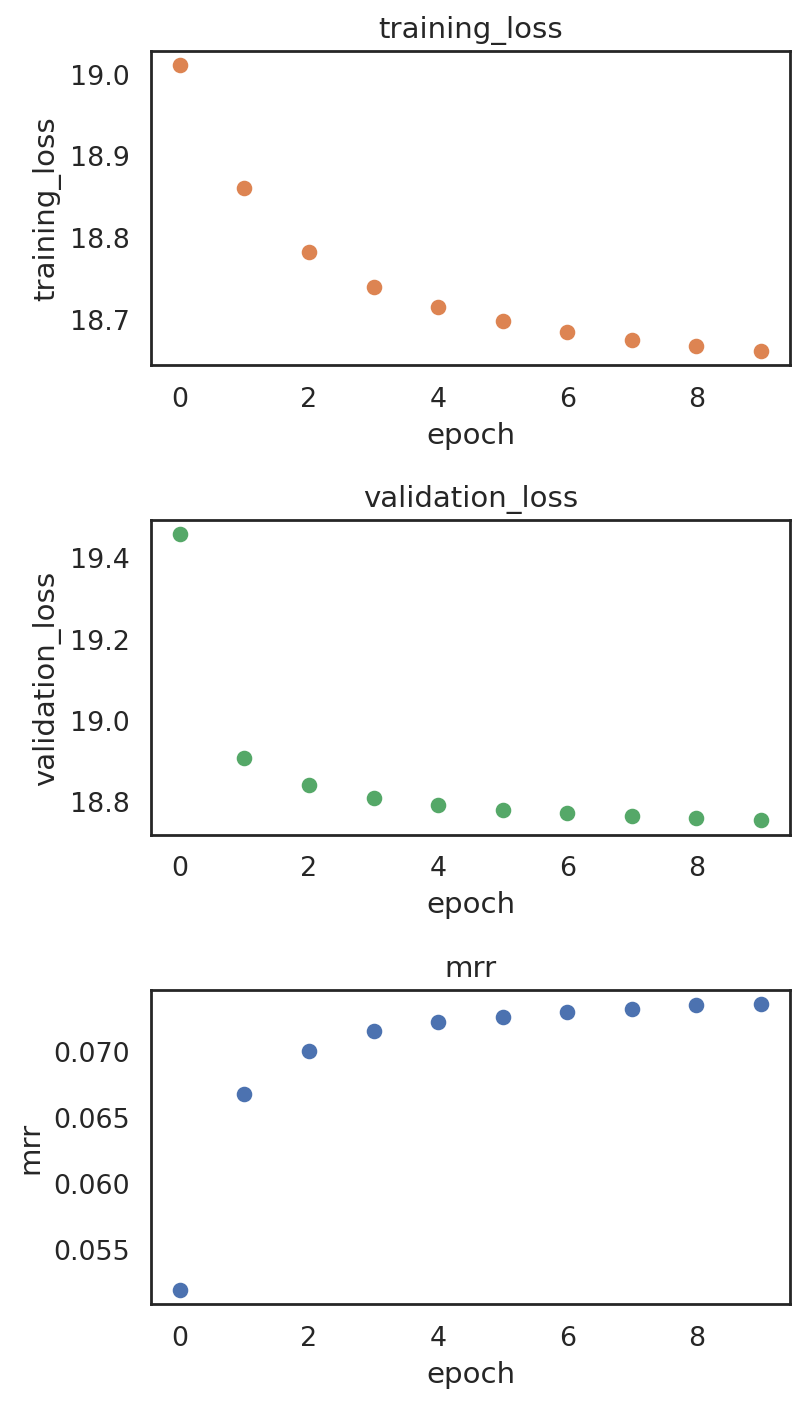

In [111]:
si.pl.pbg_metrics(fig_ncol=1)

## Post training analysis

In [112]:
dict_adata = si.read_embedding()
dict_adata

{'G': AnnData object with n_obs × n_vars = 15818 × 50,
 'C': AnnData object with n_obs × n_vars = 24581 × 50}

In [115]:
adata_C = dict_adata['C']  # embeddings of cells
adata_G = dict_adata['G']  # embeddings of genes

In [148]:
adata_C.obs = k2_adata[adata_C.obs.index].obs.copy()

In [149]:
adata_C.obs['spatialLIBD_1'] = adata[adata_C.obs['cell_1_barcode'],:].obs['spatialLIBD'].set_axis(adata_C.obs.index).copy()
adata_C.obs['spatialLIBD_2'] = adata[adata_C.obs['cell_2_barcode'],:].obs['spatialLIBD'].set_axis(adata_C.obs.index).copy()

In [165]:
 adata_C.obs.apply(lambda r: r['spatialLIBD_1', 'spatialLIBD_1'].tolist()))

SyntaxError: unmatched ')' (493784119.py, line 1)

In [168]:
adata_C.obs['spatialLIB_combined'] = adata_C.obs.apply(lambda r: '-'.join(list(np.sort(r[['spatialLIBD_1', 'spatialLIBD_2']].tolist()))), axis=1)

In [169]:
adata_C.obs['spatialLIB_combined'].value_counts()

L3-L3    6711
L1-L1    4459
L5-L5    3592
L6-L6    2494
WM-WM    1826
L4-L4    1783
L2-L2    1287
L1-L2     524
L2-L3     457
L4-L5     411
L3-L4     397
L5-L6     373
L6-WM     267
Name: spatialLIB_combined, dtype: int64

In [180]:
palette_celltype

{'L1': '#eb34a8',
 'L2': '#3486eb',
 'L3': '#34eb5b',
 'L4': '#ae34eb',
 'L5': '#ebdb34',
 'L6': '#eb9234',
 'WM': '#000000'}

In [216]:
paired_palette_celltype = {
    'L3-L3': '#34eb5b', 
    'L1-L1': '#eb34a8', 
    'L5-L5': '#ebdb34', 
    'L6-L6': '#eb9234', 
    'WM-WM': 'lightgray',#'#000000', 
    'L4-L4': '#ae34eb', 
    'L2-L2': '#3486eb', 
    'L1-L2': 'black', 
    'L2-L3': 'brown', 
    'L4-L5': 'brown', 
    'L3-L4': 'brown', 
    'L5-L6': 'brown', 
    'L6-WM': 'brown', 
}

In [220]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)

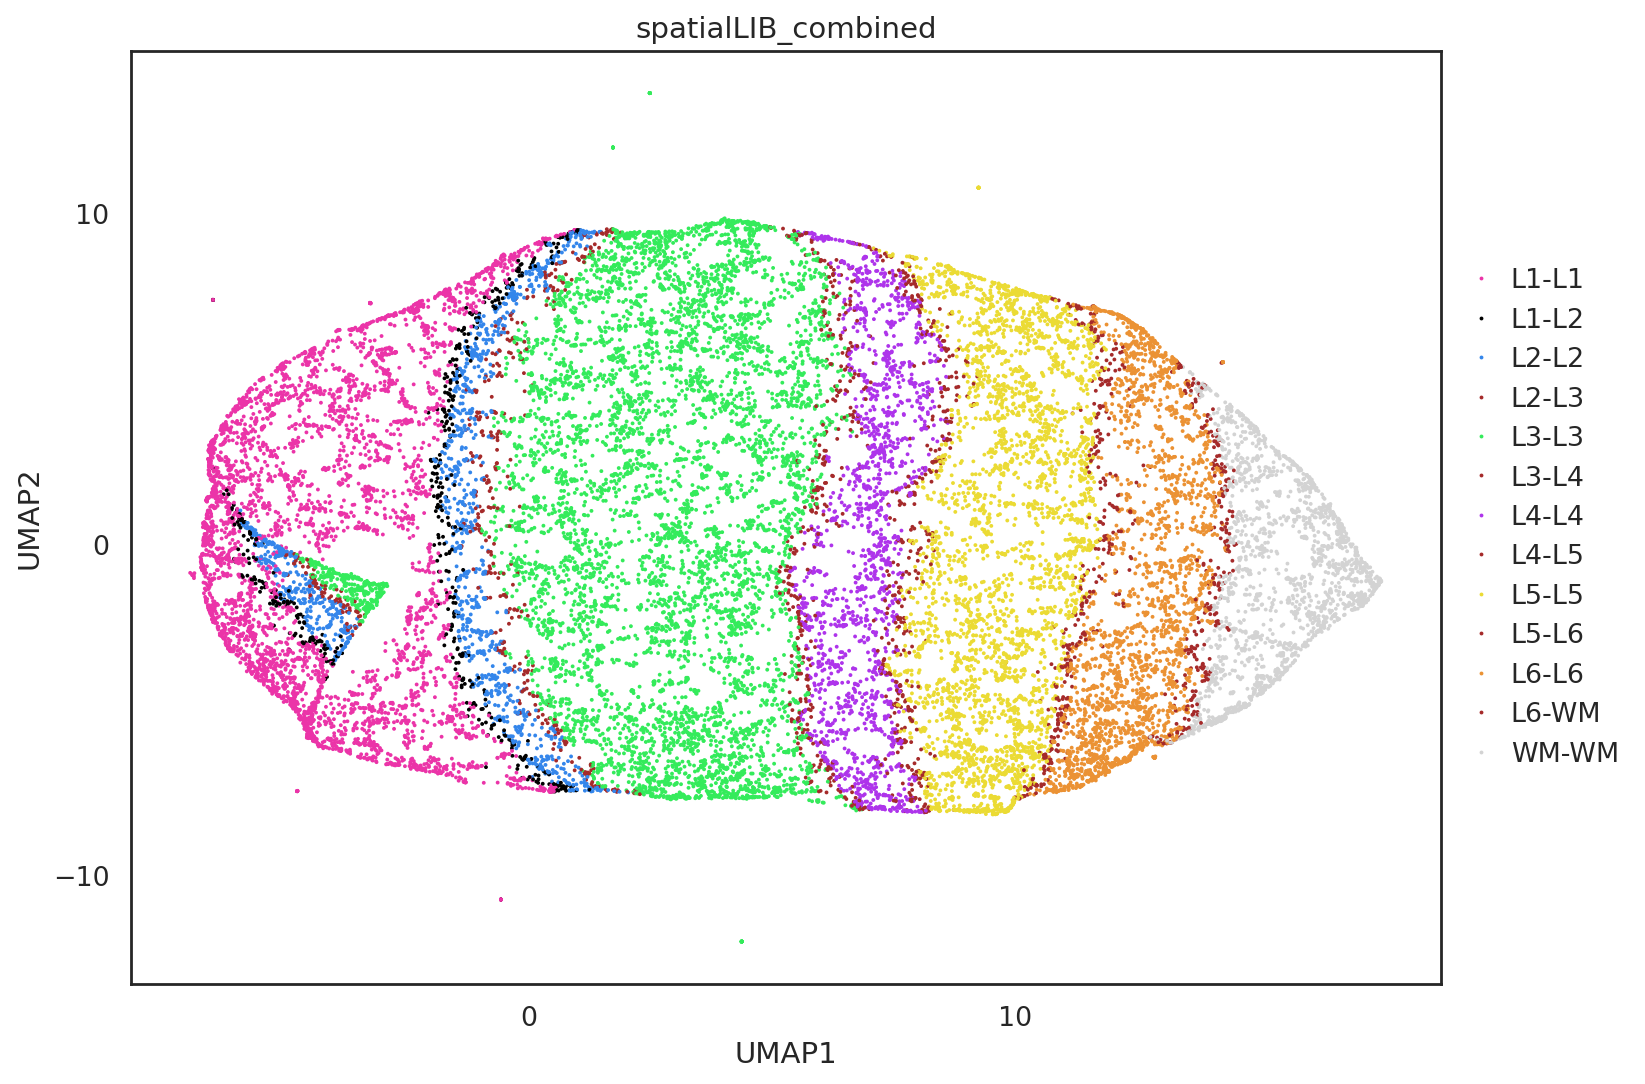

In [221]:
si.pl.umap(
    adata_C,color=['spatialLIB_combined'],
    dict_palette={'spatialLIB_combined': paired_palette_celltype},
    fig_size=(10,7),
    drawing_order='random',
    size=3
)

Since I used all possible pairs, the spatial information is encoded? Sampling all the data multiple times. 

In [184]:
sc.tl.pca(adata_C)

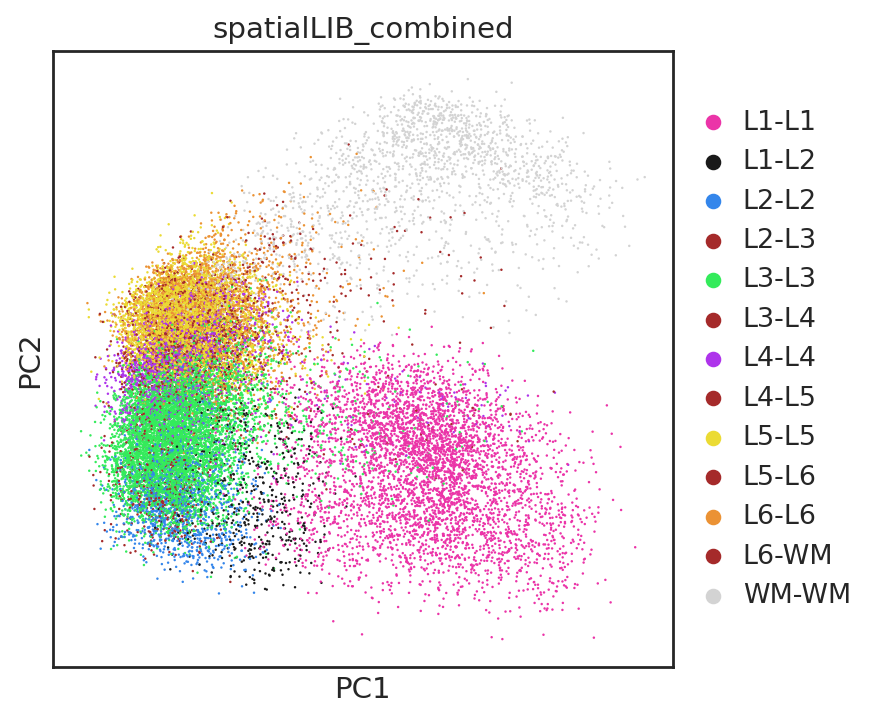

In [207]:
sc.pl.pca(adata_C, color=['spatialLIB_combined'], dimensions=(0, 1), palette=paired_palette_celltype)

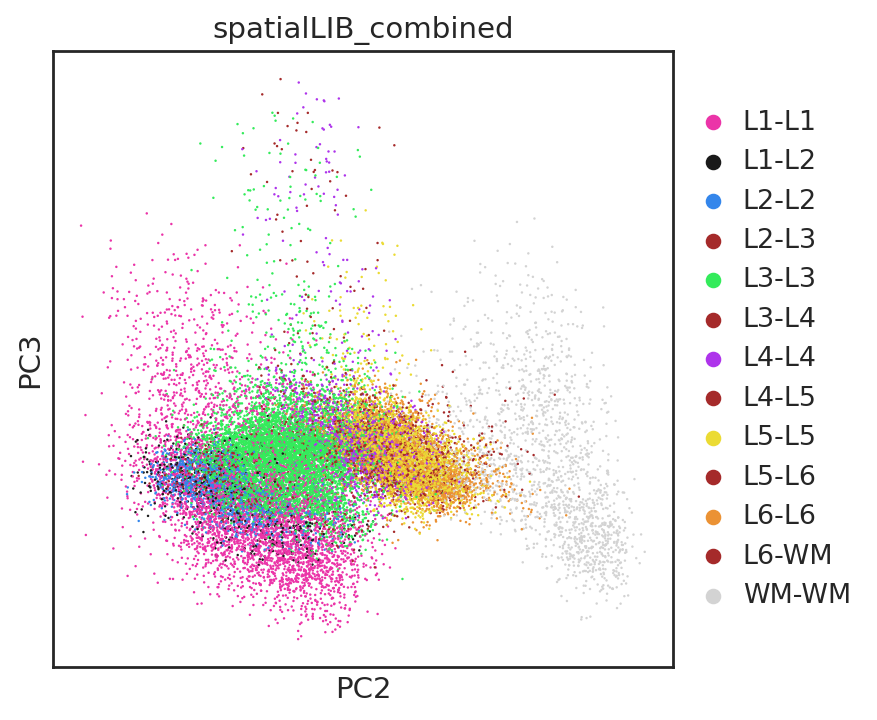

In [208]:
sc.pl.pca(adata_C, color=['spatialLIB_combined'], dimensions=(1, 2), palette=paired_palette_celltype)

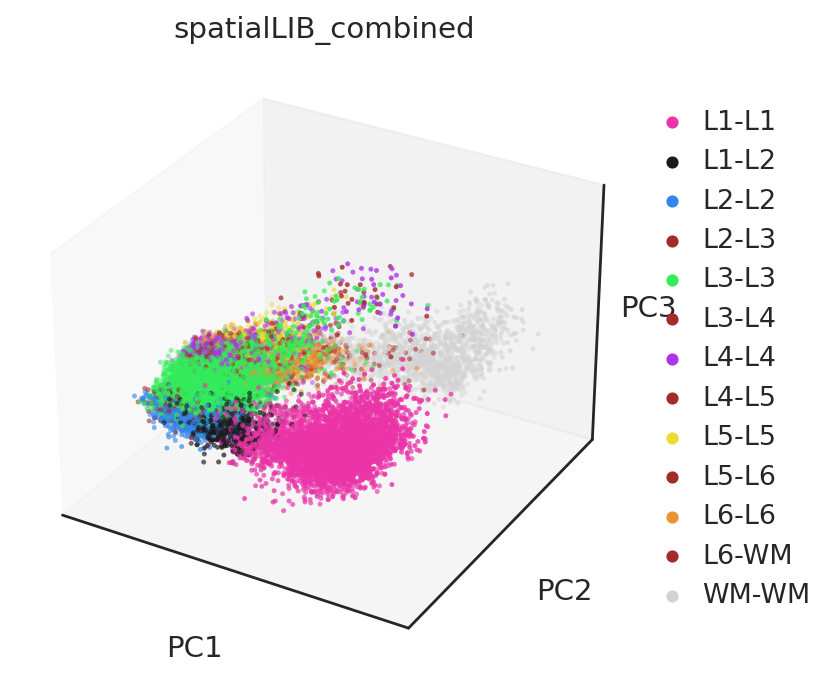

In [209]:
sc.pl.pca(adata_C, color=['spatialLIB_combined'], palette=paired_palette_celltype, projection='3d')

In [211]:
import plotly.express as px
def plotly_PCA_3d(adata, obs_col, color_discrete_map=None):
    fig = px.scatter_3d(
        x=adata.obsm['X_pca'][:, 0], 
        y=adata.obsm['X_pca'][:, 1], 
        z=adata.obsm['X_pca'][:, 2],
        color = adata.obs[obs_col],
        width=500, height=500,
        color_discrete_map=color_discrete_map
    )
    fig.update_layout(#plot_bgcolor='rgb(12,163,135)',
                      #paper_bgcolor='rgb(12,163,135)'
                      #coloraxis={"colorbar": {"x": -0.2, "len": 0.5, "y": 0.8}}, #I think this is for contours
                     scene = dict(
                                    xaxis = dict(
                                         backgroundcolor="rgba(0, 0, 0,0)",
                                         gridcolor="white",
                                         showbackground=True,
                                         zerolinecolor="white",),
                                    yaxis = dict(
                                        backgroundcolor="rgba(0, 0, 0,0)",
                                        gridcolor="white",
                                        showbackground=True,
                                        zerolinecolor="white"),
                                    zaxis = dict(
                                        backgroundcolor="rgba(0, 0, 0,0)",
                                        gridcolor="white",
                                        showbackground=True,
                                        zerolinecolor="white",),),
                     )
    fig.update_traces(marker=dict(size=2))
    fig.show()

In [215]:
paired_palette_celltype

{'L3-L3': '#34eb5b',
 'L1-L1': '#eb34a8',
 'L5-L5': '#ebdb34',
 'L6-L6': '#eb9234',
 'WM-WM': 'lightgray',
 'L4-L4': '#ae34eb',
 'L2-L2': '#3486eb',
 'L1-L2': 'k',
 'L2-L3': 'brown',
 'L4-L5': 'brown',
 'L3-L4': 'brown',
 'L5-L6': 'brown',
 'L6-WM': 'brown'}

In [219]:
plotly_PCA_3d(adata_C, obs_col='spatialLIB_combined', color_discrete_map=paired_palette_celltype)

# Cluster

In [200]:
sc.pp.neighbors(adata_C, n_neighbors=30)
sc.tl.leiden(adata_C)

/data/pinello/PROJECTS/2021_01_JY_SIMBA/simba/simba/plotting/_plot.py:783: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad)


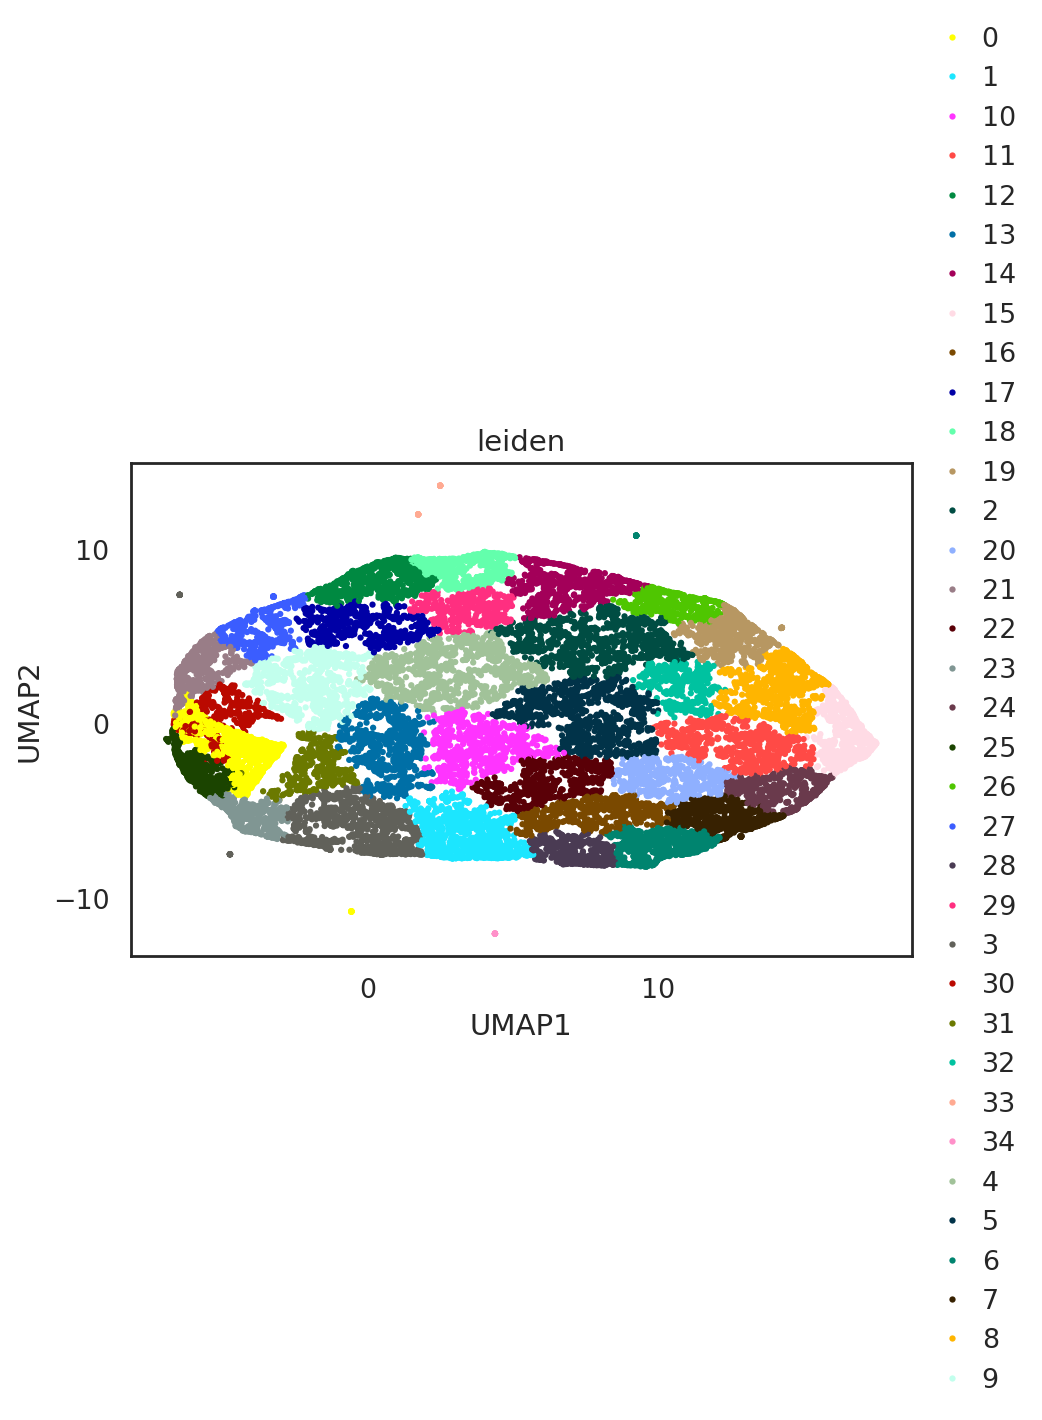

In [174]:
si.pl.umap(
    adata_C,color=['leiden'],
    # dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)